In [1]:
import warnings
# ignore warnings in the imports to keep things tidy
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import torch
import torch.nn as nn
import pyro
import pyro.contrib.bnn as bnn
from timeit import default_timer as timer
from sklearn.metrics import accuracy_score
import tensorflow as tf
import random
import time
torch.set_printoptions(threshold=100000)
np.random.seed(0)
torch.manual_seed(0)
pyro.util.set_rng_seed(0)

In [2]:
class BNN(nn.Module):
    """
        Bayesian Neural Network with two hidden layers.
        
        Major parts of the code are due to https://alsibahi.xyz/snippets/2019/06/15/pyro_mnist_bnn_kl.html
    """
    def __init__(self, in_dim, h_dim, out_dim, batch_size, lr, epochs):
        super(BNN, self).__init__()
        
        # Parameters
        self.in_dim = in_dim
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        
    def model(self, train_data, train_labels=None, kl_factor=1):
        # Prior parameters of weight distributions per layer (standard normal)
        h1_mean = torch.zeros(self.in_dim, self.h_dim-1, requires_grad=True)
        h1_mean.retain_grad()
        h1_scale = torch.ones(self.in_dim-1, self.h_dim, requires_grad=True) 
        h1_scale.retain_grad()
        h2_mean = torch.zeros(self.h_dim + 1, self.h_dim, requires_grad=True)
        h2_mean.retain_grad()
        h2_scale = torch.ones(self.h_dim + 1, self.h_dim, requires_grad=True)
        h2_scale.retain_grad()
        out_mean = torch.zeros(self.h_dim + 1, self.out_dim, requires_grad=True)
        out_mean.retain_grad()
        out_scale = torch.ones(self.h_dim + 1, self.out_dim, requires_grad=True)
        out_scale.retain_grad()
        
        # Mark batches as conditionally independent given parameters (using `plate`)
        with pyro.plate('data', size=train_data.shape[0]):            
            # Sample first hidden layer
            h1 = pyro.sample('h1', bnn.HiddenLayer(train_data, h1_mean, h1_scale, 
                                                   non_linearity=nn.functional.leaky_relu,  # Leaky ReLU activation
                                                   KL_factor=kl_factor))
            # Sample second hidden layer
            h2 = pyro.sample('h2', bnn.HiddenLayer(h1, h2_mean, h2_scale,
                                                   non_linearity=nn.functional.leaky_relu,
                                                   KL_factor=kl_factor))
            # Sample output logits
            logits = pyro.sample('logits', bnn.HiddenLayer(h2, out_mean, out_scale,
                                                           non_linearity=lambda x: nn.functional.log_softmax(x, dim=-1),
                                                           KL_factor=kl_factor,
                                                           include_hidden_bias=False))
            # One-hot encode labels
            labels = nn.functional.one_hot(train_labels) if train_labels is not None else None
            
            # Condition on observed labels, so it calculates the log-likehood loss when training using VI
            return pyro.sample('label', pyro.distributions.OneHotCategorical(logits=logits), obs=labels) 
    
    def guide(self, train_data, train_labels=None, kl_factor=1):  # Approximating function of true posterior        
        # Parameters
        # Init mean from standard normal (close to zero)
        h1_mean_tens = 0.01 * torch.randn(self.in_dim, self.h_dim)
        h1_mean = pyro.param('h1_mean', h1_mean_tens)
        h1_mean.retain_grad()
        # Init scale with smaller variance than prior parameter scale + constraint to small positive number
        h1_scale_tens = 0.1 * torch.ones(self.in_dim, self.h_dim)
        h1_scale = pyro.param('h1_scale', h1_scale_tens, constraint=torch.distributions.constraints.greater_than(0.01))
        h1_scale.retain_grad()
              
        h2_mean_tens = 0.01 * torch.randn(self.h_dim + 1, self.h_dim)
        h2_mean = pyro.param('h2_mean', h2_mean_tens)
        h2_mean.retain_grad()
        h2_scale_tens = 0.1 * torch.ones(self.h_dim + 1, self.h_dim)
        h2_scale = pyro.param('h2_scale', h2_scale_tens, constraint=torch.distributions.constraints.greater_than(0.01))
        h2_scale.retain_grad()

        out_mean = pyro.param('out_mean',0.01 * torch.randn(self.h_dim + 1, self.out_dim))
        out_mean.retain_grad()
        out_scale = pyro.param('out_scale', 0.1 * torch.ones(self.h_dim + 1, self.out_dim) , constraint=torch.distributions.constraints.greater_than(0.01))
        out_scale.retain_grad()
        
        # Sample latent values using the variational parameters that are set-up above.
        # There is no conditioning on labels in the guide!
        with pyro.plate('data', size=train_data.shape[0]):
            h1 = pyro.sample('h1', bnn.HiddenLayer(train_data, h1_mean, h1_scale, 
                                                   non_linearity=nn.functional.leaky_relu,
                                                   KL_factor=kl_factor))
            h2 = pyro.sample('h2', bnn.HiddenLayer(h1, h2_mean, h2_scale,
                                                   non_linearity=nn.functional.leaky_relu,
                                                   KL_factor=kl_factor))
            logits = pyro.sample('logits', bnn.HiddenLayer(h2, out_mean, out_scale,
                                                           non_linearity=lambda x: nn.functional.log_softmax(x, dim=-1),
                                                           KL_factor=kl_factor,
                                                           include_hidden_bias=False))
    def forward(self, x, n_samples=10):
        res = []
        for i in range(n_samples):
            t = pyro.poutine.trace(self.guide).get_trace(x)
            res.append(t.nodes['logits']['value'])
        return torch.stack(res, dim=0)  
            
    def do_training(self, X, Y):
        # Format data as tensor
        x = X
        y = Y
        if isinstance(X, np.ndarray):
            x = torch.from_numpy(X).float()
        if isinstance(Y, np.ndarray):
            y = torch.from_numpy(Y).long()

        # Specify optimizer
        optim = pyro.optim.SGD({'lr': self.lr})
        
        # Setup Variational Inference
        kl_factor = self.batch_size / x.shape[0]
        elbo = pyro.infer.TraceMeanField_ELBO()
        svi = pyro.infer.SVI(self.model, self.guide, optim, elbo)
        
        # Measure training time
        training_start = timer()
        batch_times = []
        
        for epoch in range(self.epochs):            
            # shuffle sample
            idx = torch.randperm(x.size()[0])
            x = x[idx]
            y = y[idx]

            for i in range(0, x.size()[0], self.batch_size):
                # start epoch_time
                batch_start = timer()

                # Load mini batch
                x_b = x[i:i + self.batch_size]
                y_b = y[i:i + self.batch_size]

                loss = svi.step(x_b, y_b, kl_factor=kl_factor)
                logit = self.forward(x_b).mean(0)
                y_pred = torch.argmax(logit, dim=1).detach().numpy() 
                acc = accuracy_score(y_b, y_pred)
                param_store = pyro.get_param_store() # guide parameter
                    
                batch_times.extend([timer() - batch_start])

                # Print stats
                if i/self.batch_size % 100 == 0:
                    print('Epoch:{}, Batch:{}, Loss:{}, Train Accuracy:{}, Batch Time:{}'.format(epoch, i/self.batch_size, loss, acc, batch_times[-1]))
            
        return timer() - training_start, batch_times

    def do_testing(self, x_test, n_samples=10):
        x = x_test
        if isinstance(x_test, np.ndarray):
            x = torch.from_numpy(x_test).float()
            
        self.eval()  # Enter evaluation mode
        pred = self.forward(x, n_samples=n_samples).mean(0)
        
        return pred

# Collect Training Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten and normalize data
x_train = x_train.reshape(x_train.shape[0], 784) / 255.
x_test = x_test.reshape(x_test.shape[0], 784) / 255.

### Convert labels to one vs. all 

In [4]:
to_detect = 9
num_samples = 20
print(f"First {num_samples} labels in the training data before conversion: {y_train[:num_samples]}")
# adapt data for one vs all classification
y_train_ova = np.array([1 if label == to_detect else 0 for label in y_train])
y_test_ova = np.array([1 if label == to_detect else 0 for label in y_test])
print(f"First {num_samples} labels in the training data after conversion:  {y_train_ova[:num_samples]}")

First 20 labels in the training data before conversion: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
First 20 labels in the training data after conversion:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


### Povide a more even distribution between counterexamples and examples for to_detect
The original MNIST dataset with 60.000 images for 10 digits, there exist around 6.000 images for each digit. Without this step, this would mean that we would train the BNN with ~6.000 instances of the digit described with to_detect being present and ~54.000 instances of another digit. This inequality results in a low prediction quality, which is why we include all instances of to_detect before gathering counterexamples until we have a training set that consists of 15.000 images total.

In [5]:
x_train_balanced = []
y_train_balanced = []
#for i in range(len(y_train_ova)): # First get all of the data that is meant to be detected (9)
for i in range(len(y_train_ova)): # First get all of the data that is meant to be detected (9)
    if y_train_ova[i] == 1:
        x_train_balanced.append(x_train[i])
        y_train_balanced.append(y_train_ova[i])

idx = 0
while len(x_train_balanced) < 15000: # After we have every true class examples, get enough other data
    if y_train_ova[idx] == 0:
        y_train_balanced.append(y_train_ova[idx])
        x_train_balanced.append(x_train[idx])
    idx+=1
        
x_train_balanced = np.array(x_train_balanced)
y_train_balanced = np.array(y_train_balanced)

### Distribution of counter-examples vs. true examples of to_detect before filtering

<BarContainer object of 2 artists>

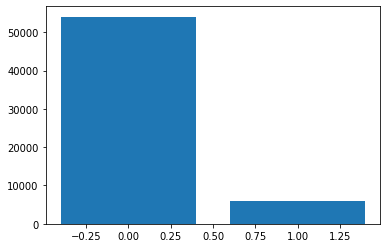

In [6]:
num_of_to_detect = np.count_nonzero(y_train == to_detect)
plt.bar([0,1],[len(y_train)-num_of_to_detect, num_of_to_detect])

### Distribution of counter-examples vs. true examples of to_detect after filtering

<BarContainer object of 2 artists>

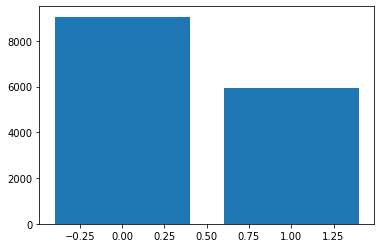

In [7]:
num_of_to_detect = np.count_nonzero(y_train_balanced == 1)
plt.bar([0,1],[len(y_train_balanced)-num_of_to_detect, num_of_to_detect])

### Shuffle the reduced training data

In [8]:
print(f"First 20 labels before shuffling: {y_train_balanced[:20]}")
adapted_y_shuffled = []
adapted_x_shuffled = []
shuffled_idx = list(range(len(y_train_balanced)))
random.shuffle(shuffled_idx)
for i in shuffled_idx:
    adapted_x_shuffled.append(x_train_balanced[i])
    adapted_y_shuffled.append(y_train_balanced[i])

adapted_x_shuffled = np.array(adapted_x_shuffled)
adapted_y_shuffled = np.array(adapted_y_shuffled)
print(f"First 20 labels after shuffling:  {adapted_y_shuffled[:20]}")

First 20 labels before shuffling: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
First 20 labels after shuffling:  [0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0]


# Instantiation and training of the Bayesian Neural Network

In [9]:
#################
# Specify Bayesian Neural Net
#################
pyro.clear_param_store()
model = BNN(in_dim=adapted_x_shuffled.shape[1],
            h_dim=100,
            out_dim=len(np.unique(adapted_y_shuffled)),
            batch_size=100,
            lr=0.0085,
            epochs=3)

#################
# Train Network
#################
training_time, batch_times = model.do_training(adapted_x_shuffled, adapted_y_shuffled)

#################
# Evaluate Network
#################
logit = model.do_testing(x_test)
y_pred = torch.argmax(logit, dim=1).detach().numpy() 
accuracy = accuracy_score(y_test_ova, y_pred)
print('#--------------------------------------------------------#')
print('Test Accuracy = {}'.format(accuracy))
print('Total Training Time = {}'.format(training_time))
print('#--------------------------------------------------------#')

Epoch:0, Batch:0.0, Loss:-988.6017456054688, Train Accuracy:0.6, Batch Time:0.27484705499955453
Epoch:0, Batch:100.0, Loss:-1038.8779296875, Train Accuracy:0.85, Batch Time:0.19327167599840323
Epoch:1, Batch:0.0, Loss:-1047.8828125, Train Accuracy:0.96, Batch Time:0.20343165000303998
Epoch:1, Batch:100.0, Loss:-1038.48681640625, Train Accuracy:0.89, Batch Time:0.2004287210002076
Epoch:2, Batch:0.0, Loss:-1064.2906494140625, Train Accuracy:0.98, Batch Time:0.18139253999834182
Epoch:2, Batch:100.0, Loss:-1059.393310546875, Train Accuracy:0.95, Batch Time:0.1655147340024996
#--------------------------------------------------------#
Test Accuracy = 0.9542
Total Training Time = 87.20922803999929
#--------------------------------------------------------#


# Definition of core functions

### Sample the weights using the Local Reparameterization Trick (Kingma et al., 2015)
i.e. sample $\epsilon \sim N(0,1)$ and fit it to the learned parameters with $w = \epsilon \cdot \sigma + \mu$

In [10]:
def sample_weights():
    params = pyro.get_param_store()
    eps_h1 = torch.from_numpy(np.random.normal(0, 1, params['h1_mean'].shape))
    h1_s = params['h1_scale']
    h1_m = params['h1_mean']
    h1_m.retain_grad()
    w_h1 = (eps_h1 * h1_s + h1_m).float()

    eps_h2 = torch.from_numpy(np.random.normal(0, 1, params['h2_mean'].shape))
    h2_s = params['h2_scale']
    h2_m = params['h2_mean']
    w_h2 = (eps_h2 * h2_s + h2_m).float()

    eps_out = torch.from_numpy(np.random.normal(0, 1, params['out_mean'].shape))
    out_s = params['out_scale']
    out_m = params['out_mean']
    w_out = (eps_out * out_s + out_m).float()
    
    return [w_h1, w_h2, w_out]

### Perform a manual forward pass
Note the .retain_grad() that is called for each output

In [11]:
def manual_forward(inputs, sampled_weights):
    net_h1 = torch.matmul(inputs, sampled_weights[0])
    out_h1 = nn.functional.leaky_relu(net_h1)
    out_h1.retain_grad()
    
    #net_h2 = torch.matmul(out_h1, sampled_weights[1][:100][:]) # 
    net_h2 = torch.matmul(out_h1, sampled_weights[1][:model.h_dim][:]) 
    # :model.h_dim in the line above to disregard the bias neuron for the sake of correct dimensions for the matrix multiplications
    out_h2 = nn.functional.leaky_relu(net_h2)
    out_h2.retain_grad()
    
    net_out = torch.matmul(out_h2, sampled_weights[2][:model.h_dim][:])
    out_out = nn.functional.log_softmax(net_out, dim=-1)
    
    return [out_h1, out_h2, out_out]

### Implementation of the LICON appraoch
Based on the pseudocode from the original paper (Kasneci et al., 2016)

In [12]:
def licon(inputs, layer_outputs):
    alpha_0 = torch.eye(inputs.shape[1])
    dims = [model.h_dim, model.h_dim, model.out_dim]
    m = len(dims)
    betas = []
    alphas= [alpha_0]
    input_dim = model.in_dim
    inputs = [inputs, layer_outputs[0], layer_outputs[1]]
    for l in range(m):
        current_layer_alphas = []
        alpha_l = torch.zeros(input_dim, dims[l])
        for i in range(dims[l]):
            layer_outputs[l][:, i].backward(retain_graph=True)
            betas.append(inputs[l].grad) # beta vector as the derivation of the output w.r.t the inputs from the prev. layer
            for k in range(input_dim):
                alpha_l[k][i] = torch.matmul(betas[-1], alphas[-1][k]) # accumulation into the alpha vector
        alphas.append(alpha_l)
    
    return alphas

In [13]:
# sample new weights, forward pass the inputs and get the global approximations (alphas) according to licon

def get_alphas(inputs):
    outs = manual_forward(inputs, sample_weights())
    return licon(inputs, outs), outs # additionally return outputs for the ability to check the actual classification

## The main contribution of the thesis

In [14]:
def get_explanation_uncertainties(idx, X, Y, num_passes=25, verbose=False, only_correct=False):
    current_img = X[idx:idx+1]
    current_img_label= Y[idx:idx+1] # 0: not the digit to detect, 1: the digit to detect
    current_img = torch.from_numpy(current_img).float()
    current_img.requires_grad = True

    measurements = [] # the measured explanations
    num_correct = 0 # the amount of correct classifications
    for i in range(num_passes):
        alphas, outs = get_alphas(current_img)
        # the differences when excluding/including wrong classifications
        # might gain interesting insights
        if not only_correct:
            measurements.append(alphas[-1][:,int(torch.argmax(outs[-1]))]) # append input contributions that lead to the decision
        if torch.argmax(outs[-1]).numpy() == current_img_label: # count correct identifications
            num_correct += 1
            if only_correct:
                measurements.append(alphas[-1][:,int(torch.argmax(outs[-1]))]) 
            
            
    mes = torch.stack(measurements)
    means = np.zeros_like(measurements[0])
    scales= np.zeros_like(measurements[0])
    # model a normal distribution for each of the explained inputs
    for i in range(model.in_dim):
        measures_for_pixel = mes[:,i].tolist()
        means[i] = np.mean(measures_for_pixel)
        scales[i]= np.std(measures_for_pixel)
    
    return means, scales, num_correct

# Testing

In [15]:
# get one index for each digit 
indices = []
for digit in range(10):
    for i in range(len(y_test)):
        if y_test[i] == digit:
            indices.append(i)
            break

#### Result after one explanation

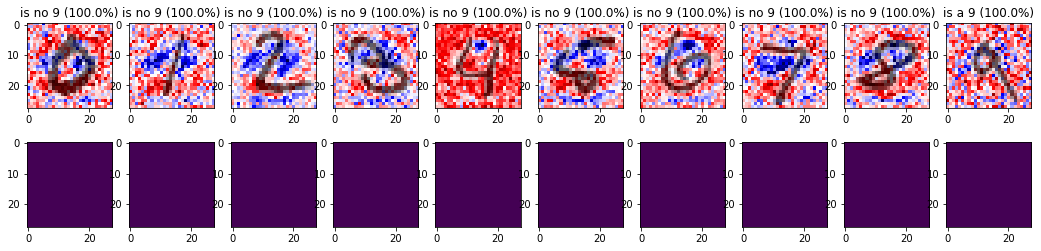

time elapsed: 23.974539041519165


In [16]:
start_time = time.time()
columns = len(indices)
f, ax = plt.subplots(2, columns, figsize=(18,4))
passes = 1 # how many explanations are generated to fit the explanatory distribution over each feature
for column in range(columns):
    image_num = indices[column]
    means, scales, correct = get_explanation_uncertainties(image_num, x_test, y_test_ova, verbose=False, num_passes=passes)
    title = ""
    if y_test_ova[image_num] == 1:
        title += f"is a {to_detect}"
    else:
        title += f"is no {to_detect}"
    title += f" ({(correct/passes)*100}%)"
    ax[0, column].imshow(means.reshape((28,28)), cmap='seismic')
    ax[0, column].set_title(title)
    current_img = x_test[image_num:image_num+1]
    masked_img = np.ma.masked_where(current_img == 0, current_img)
    ax[0,  column].imshow(masked_img.reshape((28,28)), cmap='Greys', alpha=0.6)
    ax[1,column].imshow(scales.reshape((28,28)))
plt.show()
stop_time = time.time()
print(f"time elapsed: {stop_time - start_time}") 

#### Result after ten explanations

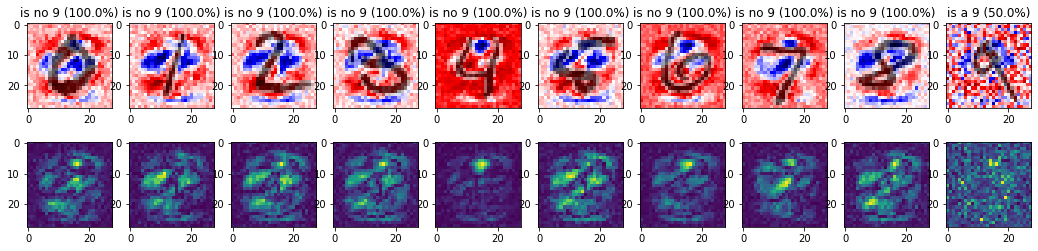

time elapsed: 234.92292523384094


In [17]:
start_time = time.time()
columns = len(indices)
f, ax = plt.subplots(2, columns, figsize=(18,4))
passes = 10 # how many explanations are generated to fit the explanatory distribution over each feature
for column in range(columns):
    image_num = indices[column]
    means, scales, correct = get_explanation_uncertainties(image_num, x_test, y_test_ova, verbose=False, num_passes=passes)
    title = ""
    if y_test_ova[image_num] == 1:
        title += f"is a {to_detect}"
    else:
        title += f"is no {to_detect}"
    title += f" ({(correct/passes)*100}%)"
    ax[0, column].imshow(means.reshape((28,28)), cmap='seismic')
    ax[0, column].set_title(title)
    current_img = x_test[image_num:image_num+1]
    masked_img = np.ma.masked_where(current_img == 0, current_img)
    ax[0,  column].imshow(masked_img.reshape((28,28)), cmap='Greys', alpha=0.6)
    ax[1,column].imshow(scales.reshape((28,28)))
plt.show()
stop_time = time.time()
print(f"time elapsed: {stop_time - start_time}") 

#### Result after 25 explanations

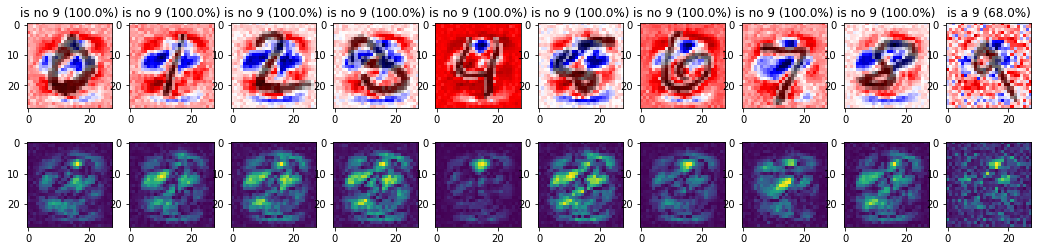

time elapsed: 649.0755002498627


In [18]:
start_time = time.time()
columns = len(indices)
f, ax = plt.subplots(2, columns, figsize=(18,4))
passes = 25 # how many explanations are generated to fit the explanatory distribution over each feature
for column in range(columns):
    image_num = indices[column]
    means, scales, correct = get_explanation_uncertainties(image_num, x_test, y_test_ova, verbose=False, num_passes=passes)
    title = ""
    if y_test_ova[image_num] == 1:
        title += f"is a {to_detect}"
    else:
        title += f"is no {to_detect}"
    title += f" ({(correct/passes)*100}%)"
    ax[0, column].imshow(means.reshape((28,28)), cmap='seismic')
    ax[0, column].set_title(title)
    current_img = x_test[image_num:image_num+1]
    masked_img = np.ma.masked_where(current_img == 0, current_img)
    ax[0,  column].imshow(masked_img.reshape((28,28)), cmap='Greys', alpha=0.6)
    ax[1,column].imshow(scales.reshape((28,28)))
plt.show()
stop_time = time.time()
print(f"time elapsed: {stop_time - start_time}") 